In [2]:
!git clone https://github.com/tensorflow/examples.git examples

Cloning into 'examples'...
Updating files:  31% (909/2902)
Updating files:  32% (929/2902)
Updating files:  33% (958/2902)
Updating files:  34% (987/2902)
Updating files:  35% (1016/2902)
Updating files:  36% (1045/2902)
Updating files:  37% (1074/2902)
Updating files:  38% (1103/2902)
Updating files:  39% (1132/2902)
Updating files:  40% (1161/2902)
Updating files:  41% (1190/2902)
Updating files:  42% (1219/2902)
Updating files:  43% (1248/2902)
Updating files:  44% (1277/2902)
Updating files:  45% (1306/2902)
Updating files:  46% (1335/2902)
Updating files:  47% (1364/2902)
Updating files:  48% (1393/2902)
Updating files:  49% (1422/2902)
Updating files:  50% (1451/2902)
Updating files:  51% (1481/2902)
Updating files:  52% (1510/2902)
Updating files:  53% (1539/2902)
Updating files:  54% (1568/2902)
Updating files:  55% (1597/2902)
Updating files:  56% (1626/2902)
Updating files:  57% (1655/2902)
Updating files:  58% (1684/2902)
Updating files:  59% (1713/2902)
Updating files:  60%

In [12]:
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import display, HTML
from PIL import Image
import io
import base64
import numpy as np
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import utils
import matplotlib.pyplot as plt

In [13]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [14]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0  # Нормализация изображения к [0, 1]
  input_mask = tf.cast(input_mask, tf.float32) - 1.0  # Сдвиг к [0, 2] (фон=0, объект=1, контур=2)
  return input_image, input_mask

In [15]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

In [16]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [17]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [19]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [20]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  titles = ['Input Image', 'True Mask', 'Predicted Mask']
  
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    if i == 0:  # Input Image (RGB)
      plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    else:  # Mask (multi-class)
      mask_array = tf.squeeze(display_list[i], axis=-1).numpy()
      colored_mask = np.zeros((mask_array.shape[0], mask_array.shape[1], 3), dtype=np.uint8)
      colored_mask[mask_array == 0] = [0, 0, 0]  # Фон (чёрный)
      colored_mask[mask_array == 1] = [0, 255, 0]  # Объект (зелёный)
      colored_mask[mask_array == 2] = [255, 255, 0]  # Контур (жёлтый)
      plt.imshow(colored_mask)
    plt.axis('off')
  plt.show()

Форма sample_image: (128, 128, 3) Мин/Макс: 0.0 2.0
Форма sample_mask: (128, 128, 1) Мин/Макс: 0.0 2.0
Уникальные значения маски: [0. 1. 2.]


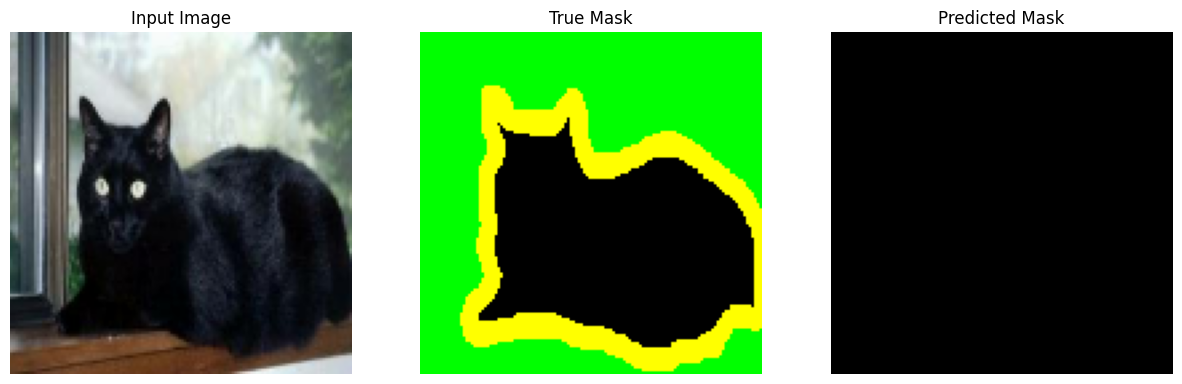

Форма sample_image: (128, 128, 3) Мин/Макс: 0.0 2.0
Форма sample_mask: (128, 128, 1) Мин/Макс: 0.0 2.0
Уникальные значения маски: [0. 1. 2.]


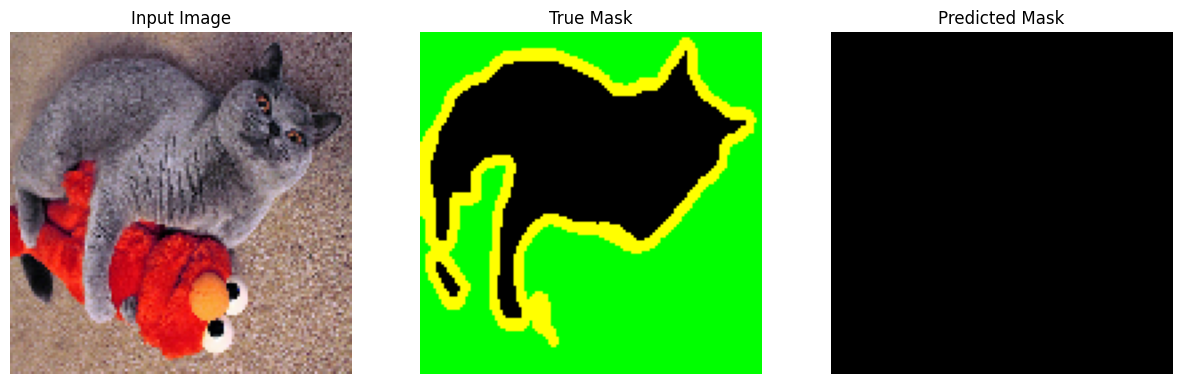

In [21]:
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    print("Форма sample_image:", sample_image.shape, "Мин/Макс:", tf.reduce_min(sample_mask).numpy(), tf.reduce_max(sample_mask).numpy())
    print("Форма sample_mask:", sample_mask.shape, "Мин/Макс:", tf.reduce_min(sample_mask).numpy(), tf.reduce_max(sample_mask).numpy())
    print("Уникальные значения маски:", np.unique(sample_mask.numpy()))
    display([sample_image, sample_mask, tf.zeros_like(sample_mask)])

In [22]:
def create_unet_model():
  inputs = Input(shape=(128, 128, 3))

  # Encoder
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  pool1 = Dropout(0.2)(pool1)

  conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  pool2 = Dropout(0.2)(pool2)

  # Bottleneck
  conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

  # Decoder
  up4 = UpSampling2D(size=(2, 2))(conv3)
  up4 = Concatenate()([up4, conv2])
  conv4 = Conv2D(128, 3, activation='relu', padding='same')(up4)
  conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
  conv4 = Dropout(0.2)(conv4)

  up5 = UpSampling2D(size=(2, 2))(conv4)
  up5 = Concatenate()([up5, conv1])
  conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
  conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)
  conv5 = Dropout(0.2)(conv5)

  # Output layer
  outputs = Conv2D(1, 1, activation='sigmoid')(conv5)

  model = Model(inputs=inputs, outputs=outputs)
  return model

In [23]:
model = create_unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ dropout_2[0][0] 

 Total params: 1,883,137 (7.18 MB)

 Trainable params: 1,883,137 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         validation_steps=VALIDATION_STEPS,
                         validation_data=test_batches)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 917s 16s/step - accuracy: 0.5757 - loss: 0.5904 - val_accuracy: 0.5733 - val_loss: -8.1928
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1142s 20s/step - accuracy: 0.5867 - loss: 9.7085 - val_accuracy: 0.5733 - val_loss: 0.6025
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 644s 11s/step - accuracy: 0.5904 - loss: 0.4968 - val_accuracy: 0.5733 - val_loss: 0.5584
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 387s 7s/step - accuracy: 0.5894 - loss: -1040.9517 - val_accuracy: 0.5733 - val_loss: -315254.0312
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 384s 7s/step - accuracy: 0.5848 - loss: -2195147520.0000 - val_accuracy: 0.5733 - val_loss: -409365839872.0000
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 383s 7s/step - accuracy: 0.5840 - loss: -11210114203648.0000 - val_accuracy: 0.5733 - val_loss: -537807449751552.0000
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 383s 7s/step - accuracy: 0.5879 - loss: -4093191074611200.0000 - val_accuracy: 0.5733 - val_loss: -70095433933783040.0000
Epoch 8/20
5

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 941ms/step


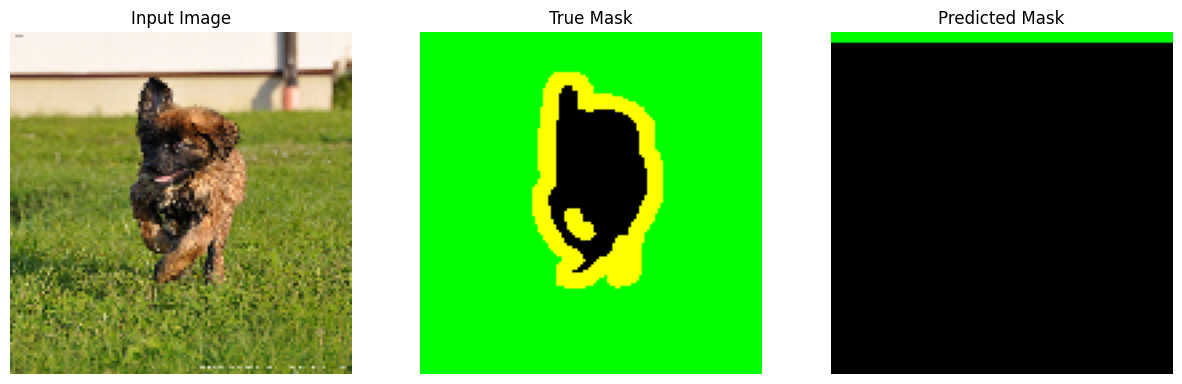

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 933ms/step


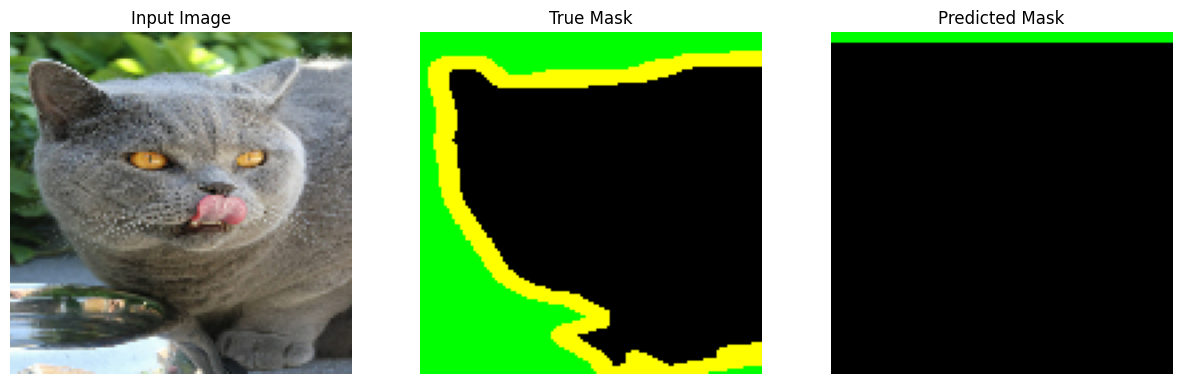

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 925ms/step


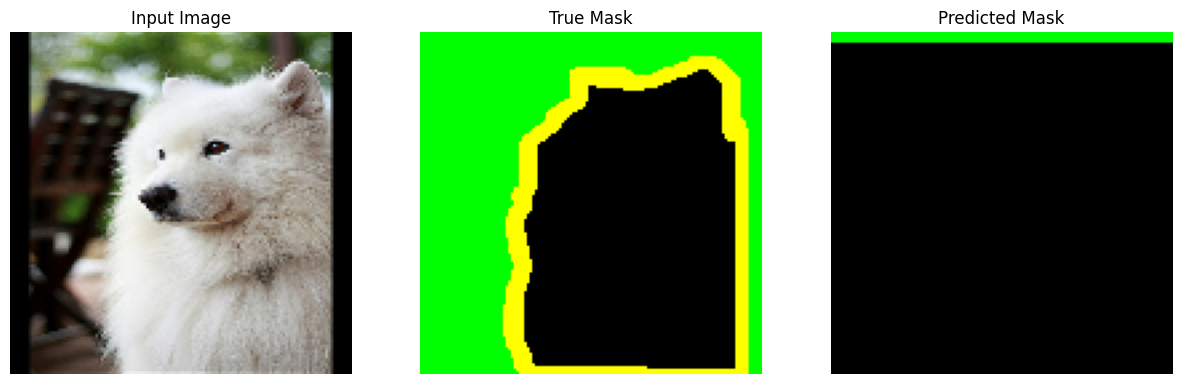

In [26]:
def show_predictions(dataset, num=1):
  for image, mask in dataset.take(num):
    pred_mask = model.predict(image)
    display([image[0], mask[0], pred_mask[0]])

show_predictions(test_batches, 3)